# Predicción de diabetes 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from xgboost import plot_importance
import shap

sns.set_theme(style="whitegrid")

/workspaces/DiabetesScreening/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Card


### Ficha Técnica del Dataset: Pima Indians Diabetes Database 

Este conjunto de datos proviene originalmente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales. Su objetivo es predecir diagnósticamente si un paciente padece diabetes, basándose en ciertas mediciones diagnósticas incluidas en el conjunto de datos. Se aplicaron varias restricciones a la selección de estos casos de una base de datos más amplia. En particular, todos los pacientes aquí presentes son mujeres de al menos 21 años de ascendencia indígena pima.

### 0.1. Metadatos Principales
| Característica | Detalle |
| :--- | :--- |
| **Fuente Original** | Kaggle |
| **Tipo de Problema** | Clasificación binaria |
| **Instancias (Filas)** | 2,460 (pacientes) |
| **Variables (Columnas)** | 8 características + Target |
| **Tipo de Atributos** | Enteros, Reales |
| **Datos Faltantes** | No se observan valoren nulos o faltantes |


### 0.2. Diccionario de Datos (Variables)
Entender qué significa cada columna es crucial para el análisis:

* **Variables Características:**
- `Embarazos (Pregnancies):` número de veces que la paciente ha estado embarazada.  
- `Glucosa (Glucose):` concentración de glucosa plasmática medida a las 2 horas durante una prueba oral de tolerancia a la glucosa.  
- `Presión arterial (Blood Pressure):` presión arterial diastólica, medida en mm Hg.  
- `Espesor del pliegue cutáneo (Skin Thickness):` espesor del pliegue cutáneo del tríceps, medido en milímetros.  
- `Insulina (Insulin):` nivel de insulina sérica a las 2 horas, medido en µU/ml.
- `IMC(BMI):`Índice de masa corporal (BMI) (peso en kg/(altura en m)^2)
- `Función de pedigrí de diabetes (Diabetes Pedigree Function):` índice que estima la probabilidad de diabetes en función del historial familiar.  
- `Edad (Age):` edad de la paciente, expresada en años.  

* **Variable Objetivo (Target):**
    * `Resultado (Outcome)`: variable objetivo o de clasificación (0 o 1), donde **1** indica un diagnóstico positivo de diabetes y **0** un diagnóstico negativo.

In [2]:
#cargar el dataset
df = pd.read_csv("Training.csv")

#mostrar primeras filas
df.head(10)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [3]:
#mostrar información del dataset 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460 entries, 0 to 2459
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2460 non-null   int64  
 1   Glucose                   2460 non-null   int64  
 2   BloodPressure             2460 non-null   int64  
 3   SkinThickness             2460 non-null   int64  
 4   Insulin                   2460 non-null   int64  
 5   BMI                       2460 non-null   float64
 6   DiabetesPedigreeFunction  2460 non-null   float64
 7   Age                       2460 non-null   int64  
 8   Outcome                   2460 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 173.1 KB


In [4]:
#mostrar descripción del dataset

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,2460.0,3.817480,3.296458,0.000,1.00000,3.000,6.000,17.00
Glucose,2460.0,121.602033,31.789270,0.000,100.00000,117.000,142.000,197.00
BloodPressure,2460.0,68.915041,19.082655,0.000,64.00000,70.000,80.000,122.00
SkinThickness,2460.0,20.531301,15.716901,0.000,0.00000,23.000,33.000,63.00
Insulin,2460.0,80.119919,116.765807,0.000,0.00000,36.000,129.000,846.00
BMI,2460.0,31.990447,7.802569,0.000,27.10000,32.100,36.500,67.10
DiabetesPedigreeFunction,2460.0,0.491440,0.363917,0.078,0.25175,0.381,0.647,2.42
Age,2460.0,32.821951,11.251208,21.000,24.00000,29.000,39.000,81.00
Outcome,2460.0,0.390244,0.487904,0.000,0.00000,0.000,1.000,1.00


### Limpieza de datos 

Como se pudo observar al utilizar el método describe, existen varias columnas donde el valor mínimo es cero; sin embargo, esto no es realista para las columnas Glucose, BloodPressure, SkinThickness, Insulin y BMI, por lo que estos datos se deben transformar a NaN:

In [5]:
#crear copia de conjunto original
df_copy = df.copy()
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [6]:
#Reemplazar valores cero en las columnas donde ese valor es ilógico por NaN
df_copy[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI']] = df_copy[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI']].replace(0,np.nan)

In [7]:
#A continuación se observa el dataset con los valores faltantes:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460 entries, 0 to 2459
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2460 non-null   int64  
 1   Glucose                   2443 non-null   float64
 2   BloodPressure             2346 non-null   float64
 3   SkinThickness             1743 non-null   float64
 4   Insulin                   1279 non-null   float64
 5   BMI                       2429 non-null   float64
 6   DiabetesPedigreeFunction  2460 non-null   float64
 7   Age                       2460 non-null   int64  
 8   Outcome                   2460 non-null   int64  
dtypes: float64(6), int64(3)
memory usage: 173.1 KB


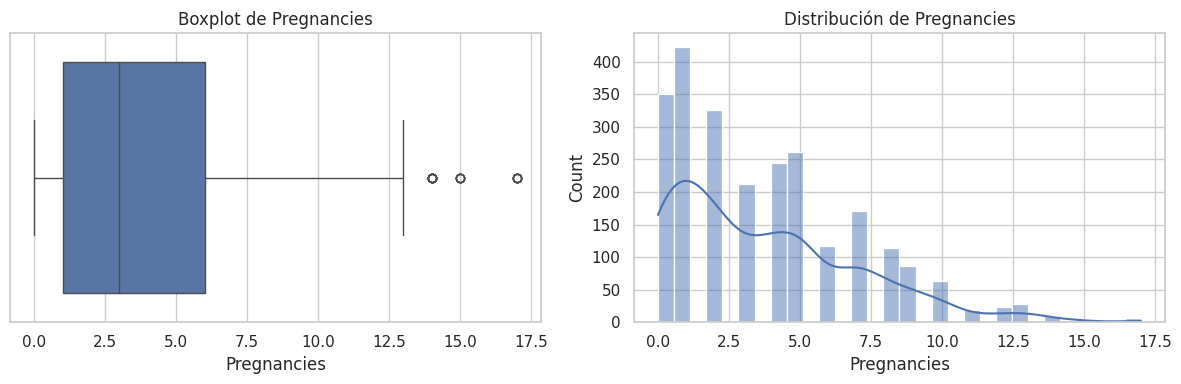

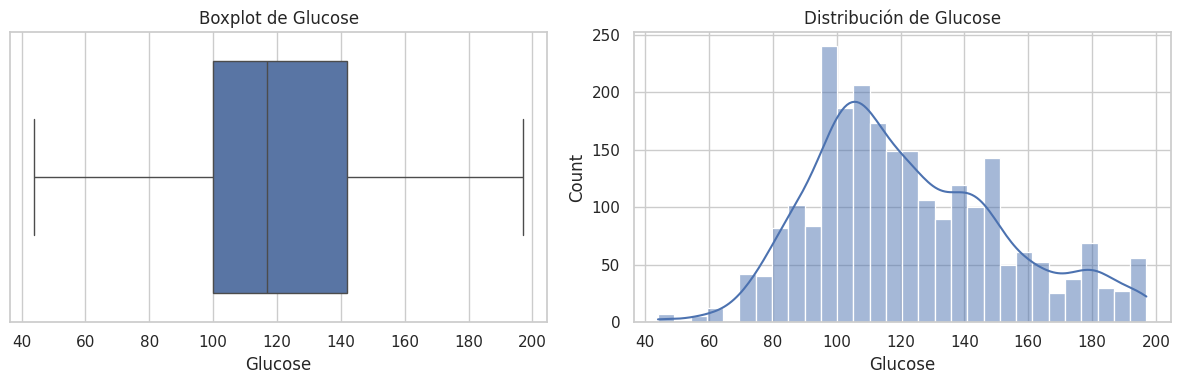

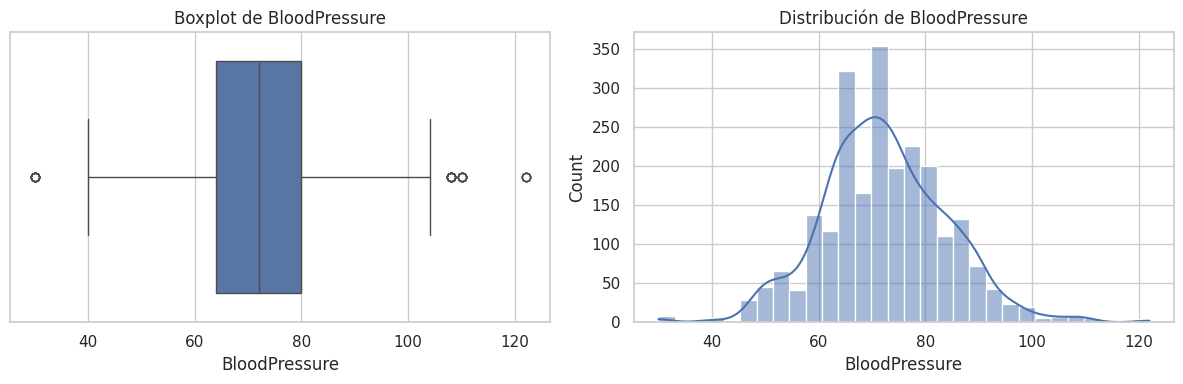

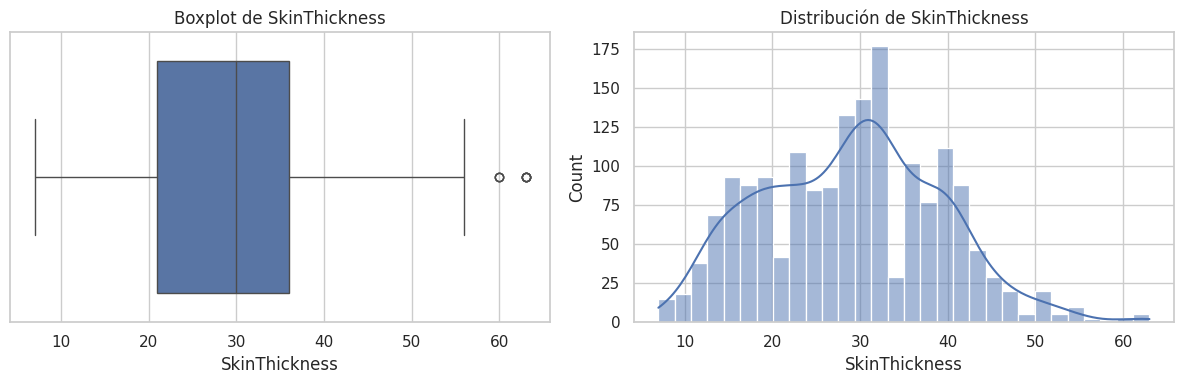

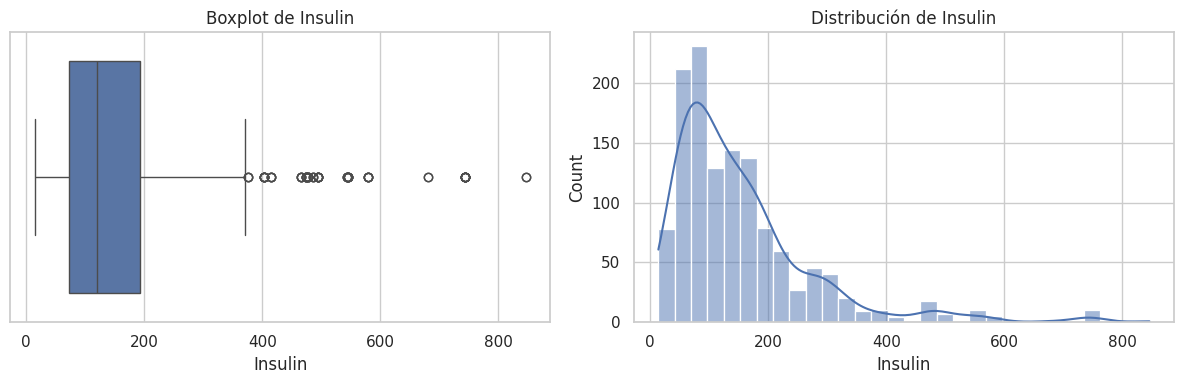

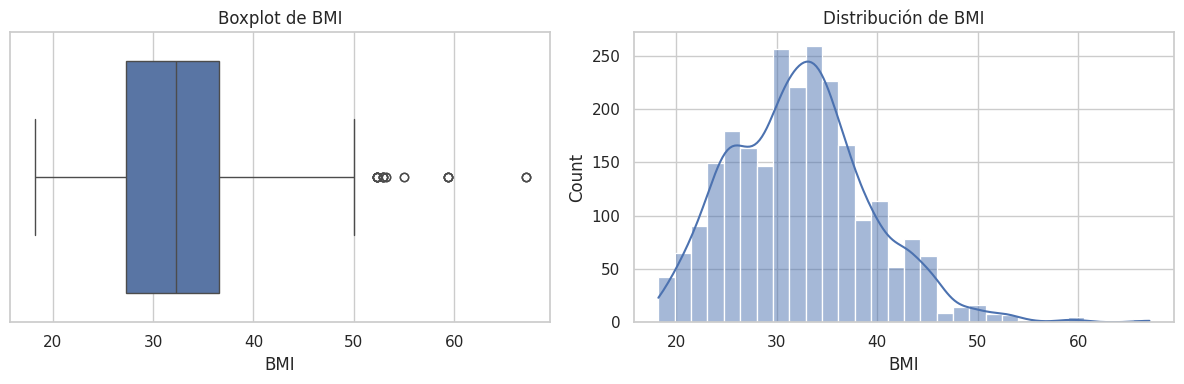

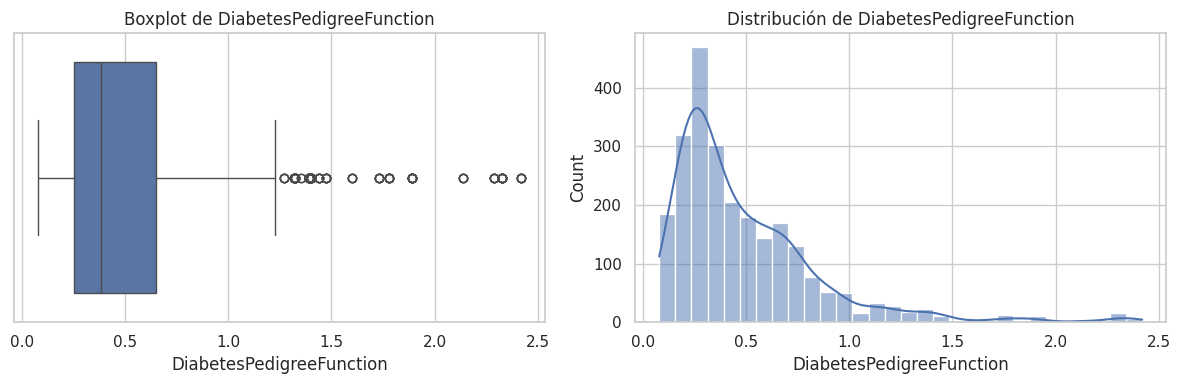

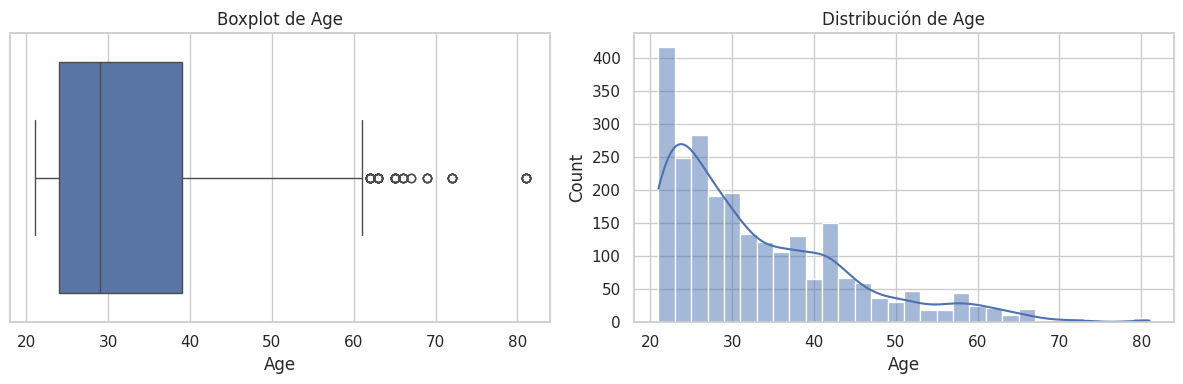

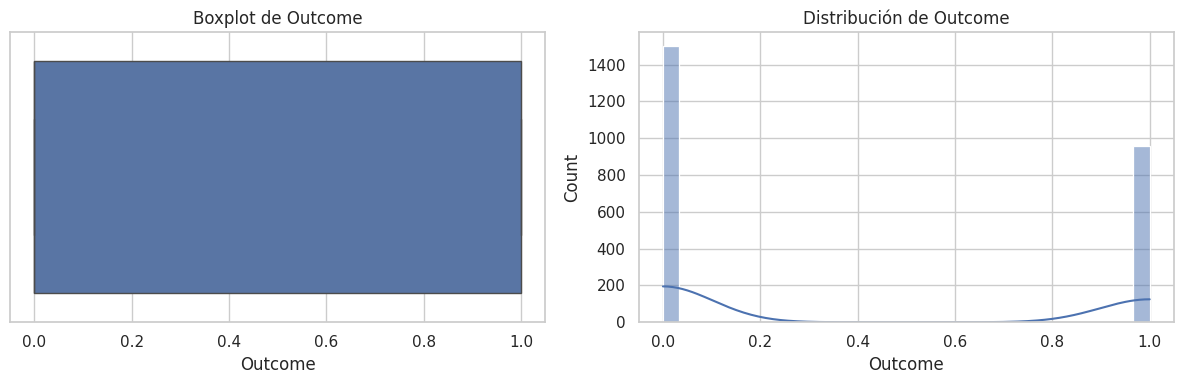

In [8]:
%matplotlib inline
#Seleccionar datos numéricos únicamente
numeric_cols = df_copy.select_dtypes(include="number").columns
#omitir columnas constantes
numeric_cols = [c for c in numeric_cols if df_copy[c].nunique() > 1]

#Boxplot para todas las columnas numéricas y distribución de variables
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.boxplot(x=df_copy[col], ax=axes[0])
    axes[0].set_title(f"Boxplot de {col}")

    sns.histplot(df_copy[col], kde=True, bins=30, ax=axes[1])
    axes[1].set_title(f"Distribución de {col}")

    plt.tight_layout()
    plt.show()

Como se puede observar, la gran mayoría de los histogramas presentan distribuciones sesgadas, principalmente cargadas hacia la izquierda. Asimismo, se identifican varios outliers o valores atípicos con excepción de la columna glucosa. En este contexto, imputar los valores faltantes utilizando la media podría introducir valores erróneos, ya que la media es sensible tanto a la asimetría como a la presencia de valores extremos. Por lo tanto, resulta más adecuado imputar mediante la mediana, dado que esta es una medida de tendencia central más robusta frente a valores atípicos.

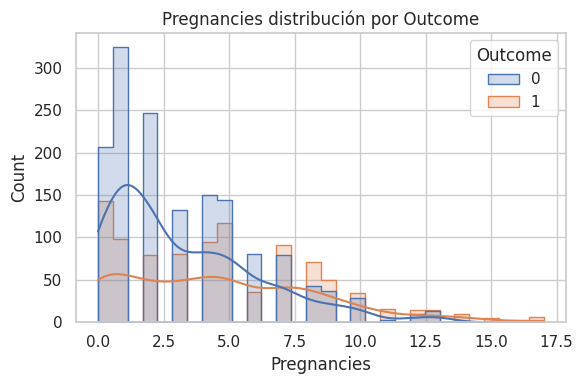

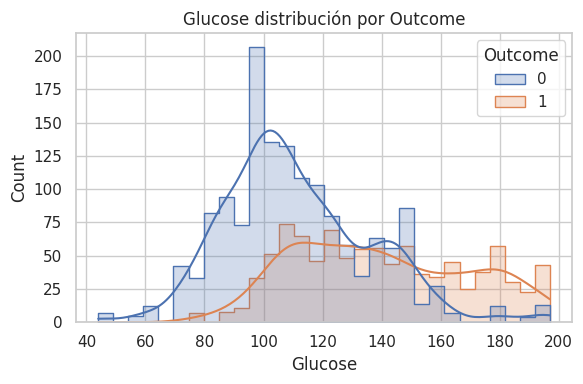

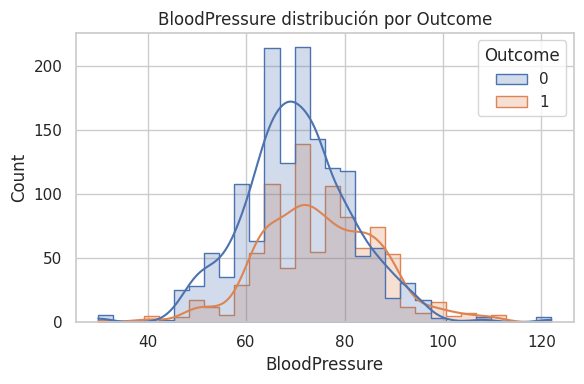

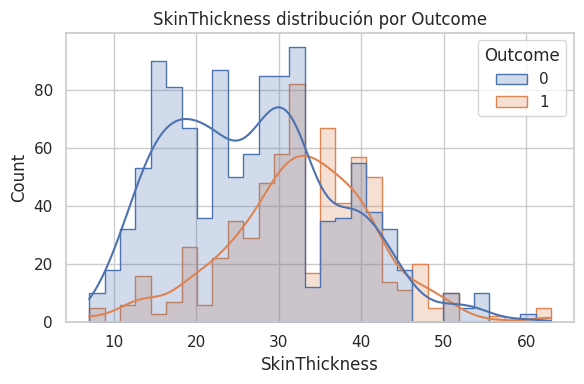

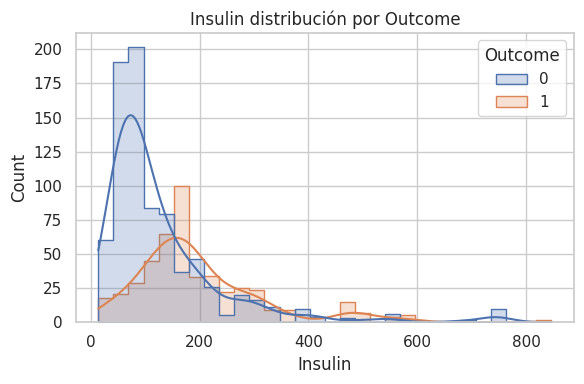

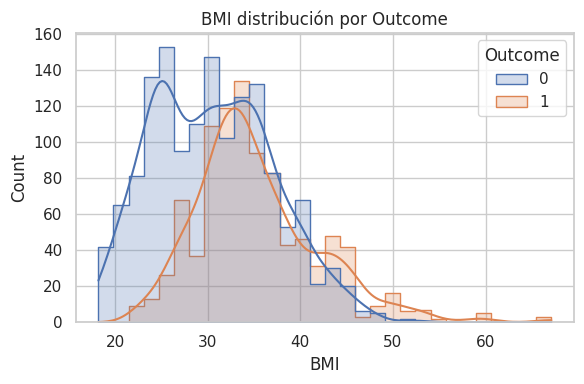

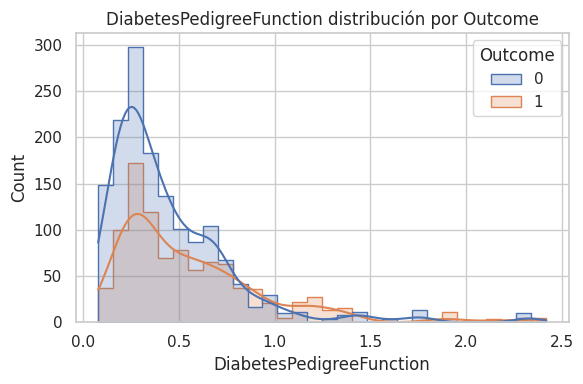

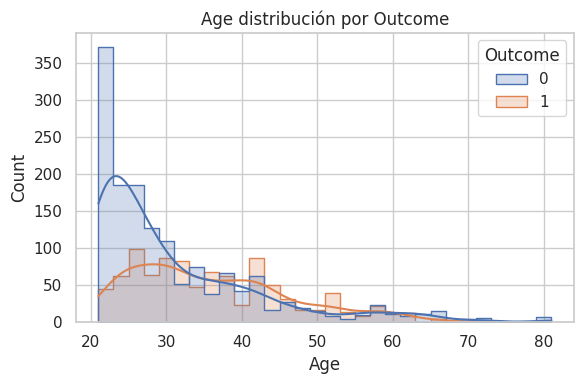

In [9]:
#Distribución por variable objetivo
target_col = "Outcome"

for col in numeric_cols:
    if col != target_col:
        plt.figure(figsize=(6, 4))
        sns.histplot(
            data=df_copy,
            x=col,
            hue=target_col,
            kde=True,
            bins=30,
            element="step"
        )
        plt.title(f"{col} distribución por {target_col}")
        plt.tight_layout()
        plt.show()


### Imputación de valores faltantes

In [10]:
#Como se observó la columna Glucose, no presenta outliers, por lo que sus valores faltantes se imputan por la media:

df_copy['Glucose'] = df_copy['Glucose'].fillna(df_copy['Glucose'].mean())

#Con las columnas restantes se imputa por la mediana:
df_copy['BloodPressure'] = df_copy['BloodPressure'].fillna(df_copy['BloodPressure'].median())
df_copy['SkinThickness'] = df_copy['SkinThickness'].fillna(df_copy['SkinThickness'].median())
df_copy['Insulin'] = df_copy['Insulin'].fillna(df_copy['Insulin'].median())
df_copy['BMI'] = df_copy['BMI'].fillna(df_copy['BMI'].median())

In [11]:
#Verificar con describe que los ceros ilógicos no estan más presentes:
df_copy.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000
mean,3.817480,122.448219,72.251626,29.275203,137.729675,32.397480,0.491440,32.821951,0.390244
std,3.296458,30.126696,11.544409,8.588621,89.414037,6.914762,0.363917,11.251208,0.487904
min,0.000000,44.000000,30.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,101.000000,64.000000,25.000000,119.000000,27.400000,0.251750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,30.000000,120.000000,32.300000,0.381000,29.000000,0.000000
75%,6.000000,142.000000,80.000000,33.000000,129.000000,36.500000,0.647000,39.000000,1.000000
max,17.000000,197.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Distribución variable objetivo

In [12]:
df_copy["Outcome"].value_counts()

Outcome
0    1500
1     960
Name: count, dtype: int64

Como se puede observar, la variable objetivo presenta un desbalanceo significativo, por lo que se aplicaran tecnicas de sobremuestro para balancear el target.

In [13]:
#Definimos nuestras variables predictoras (X) y nuestra variable objetivo (y)

X = df_copy.drop(columns='Outcome', axis =1)
y = df_copy['Outcome']

###  Preparación de los datos (Split Train-Test)


In [14]:
# Dividimos en Train y Test (80% train, 20% test) con stratify y para asegurarnos de que la proporción de clases se mantenga igual tanto en el conjunto de entrenamiento como en el de prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Datos de entrenamiento: {X_train.shape}")
print(f"Datos de prueba: {X_test.shape}")

Datos de entrenamiento: (1968, 8)
Datos de prueba: (492, 8)


### Sobremuestro del conjunto de datos con técnica SMOTE

SMOTE (siglas en inglés de Synthetic Minority Over-sampling Technique o Técnica de Sobremuestreo de Minorías Sintéticas) es un algoritmo de aprendizaje automático utilizado para abordar conjuntos de datos desequilibrados. 
En lugar de simplemente replicar datos de la clase minoritaria (lo que puede causar sobreajuste), SMOTE crea nuevas muestras sintéticas (artificiales) que son similares a las ya existentes, interpolando entre puntos de datos de la clase minoritaria cercanos

In [15]:
from imblearn.over_sampling import SMOTE

#Definir método de sobremuestro

smote = SMOTE()
#Se recomienda aplicar el sobremuestreo únicamente en la clase de entrenamiento
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [16]:
print('Distribución tras aplicar técnica SMOTE:\n', y_train_resampled.value_counts())

Distribución tras aplicar técnica SMOTE:
 Outcome
1    1200
0    1200
Name: count, dtype: int64


### Estandarización

Se procede a estandarizar las variables para evitar que aquellas con magnitudes mayores, como la glucosa, tengan una influencia desproporcionada sobre el modelo frente a otras variables. 

In [17]:
scaler = StandardScaler()
#Ajustar el escalador SÓLO a los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train_resampled)
#Transformar datos de prueba
X_test_scaled =  scaler.transform(X_test)

### Entrenar modelo de Regresión Logística, Decision Tree y XGBoost

In [18]:
#1. Se instancia y entrena una Regresión logístca

# Instanciar (aumentamos max_iter para asegurar que converja la matemática)
logreg = LogisticRegression(max_iter=1000)

# Entrenar con conjunto de entrenamiento estandarizado
logreg.fit(X_train_scaled, y_train_resampled)

# Predecir
y_pred_logreg = logreg.predict(X_test_scaled)

#2. Se instancia y entrena un árbol de decisión

#Instanciar Árbol Regularizado (Limitado) para evitar el overfitting o sobreajuste
tree = DecisionTreeClassifier(max_depth=5, random_state=42)

# Entrenar
tree.fit(X_train, y_train)

#Predecir
y_pred_tree = tree.predict(X_test)

#3. Se instancia y entrena un clasificador XGboost o potenciación de gradiente extrema

xgb = XGBClassifier(max_depth=5, random_state=42)

# Entrenar
xgb.fit(X_train, y_train)

#Predecir
y_pred_xgb = xgb.predict(X_test)

# 4. Se calcula el accuracy de ambos modelos en train y test

models = {
    "Logistic Regression": logreg,
    "Decision Tree": tree,
    "XGBoost": xgb
}

results = []

for name, model in models.items():
    if name == "Logistic Regression":
        train_acc = accuracy_score(y_train_resampled, model.predict(X_train_scaled))
        test_acc = accuracy_score(y_test, model.predict(X_test_scaled))
    else:
        train_acc = accuracy_score(y_train, model.predict(X_train))
        test_acc = accuracy_score(y_test, model.predict(X_test))
    
    results.append({
        "Model": name,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc
    })

results_df = pd.DataFrame(results)
print(results_df)

                 Model  Train Accuracy  Test Accuracy
0  Logistic Regression        0.699583       0.695122
1        Decision Tree        0.799289       0.792683
2              XGBoost        1.000000       0.995935


### Classification Report

In [19]:
print('Classification report Logistic Regression:\n', classification_report(y_test, y_pred_logreg, target_names=['0', '1']))
print('Classification report Decision Tree:\n', classification_report(y_test, y_pred_tree, target_names=['0', '1']))
print('Classification report XGBoost:\n', classification_report(y_test, y_pred_xgb, target_names=['0', '1']))

Classification report Logistic Regression:
               precision    recall  f1-score   support

           0       0.77      0.72      0.74       300
           1       0.60      0.66      0.63       192

    accuracy                           0.70       492
   macro avg       0.68      0.69      0.69       492
weighted avg       0.70      0.70      0.70       492

Classification report Decision Tree:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       300
           1       0.78      0.65      0.71       192

    accuracy                           0.79       492
   macro avg       0.79      0.77      0.77       492
weighted avg       0.79      0.79      0.79       492

Classification report XGBoost:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       300
           1       0.99      1.00      0.99       192

    accuracy                           1.00       492
   macro avg  

##  Interpretación (White Box)

---VARIABLES Y COEFICIENTES DE REGRESIÓN LOGÍSTICA---
                   Variable  Coefficient
1                   Glucose     1.121848
5                       BMI     0.575984
0               Pregnancies     0.289414
6  DiabetesPedigreeFunction     0.278168
7                       Age     0.097259
3             SkinThickness     0.064797
2             BloodPressure     0.033730
4                   Insulin    -0.264947
--- VARIABLES CLAVE SEGÚN EL ÁRBOL ---
                   Variable  Importancia
1                   Glucose     0.496990
5                       BMI     0.240943
7                       Age     0.081370
4                   Insulin     0.072303
6  DiabetesPedigreeFunction     0.051434
3             SkinThickness     0.036937
0               Pregnancies     0.015973
2             BloodPressure     0.004050


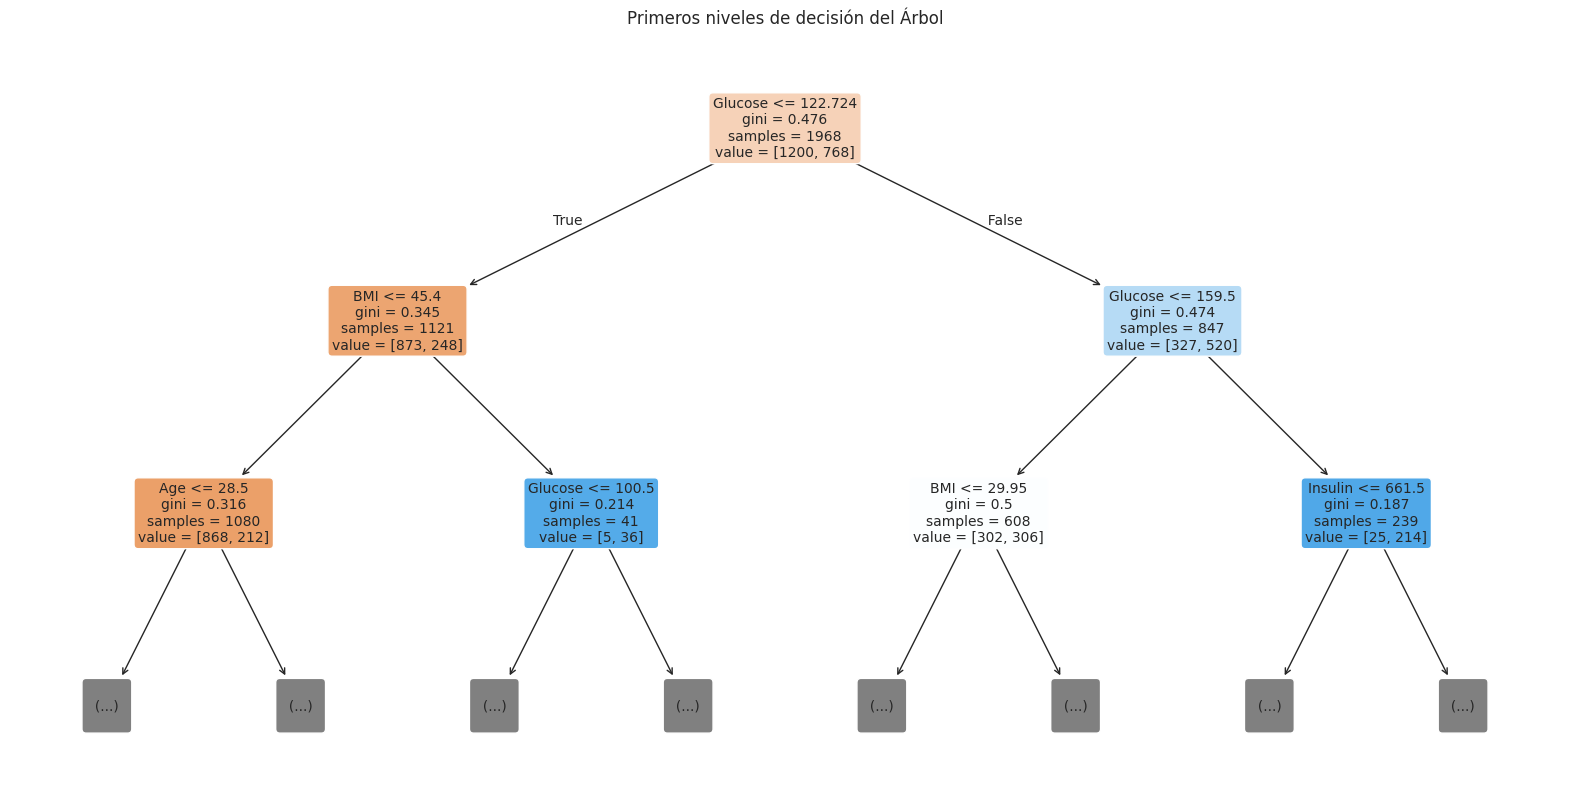

--- VARIABLES CLAVE SEGÚN CLASIFICADOR XGBOOST ---
Glucose                     6.743086
BMI                         4.117685
Age                         3.851219
DiabetesPedigreeFunction    3.025130
Insulin                     2.909396
SkinThickness               2.798537
BloodPressure               2.597896
Pregnancies                 2.193551
dtype: float64
--- VISUALIZAR VARIABLES CLAVE CLASIFICADOR XGBOOST CON SHAP ---


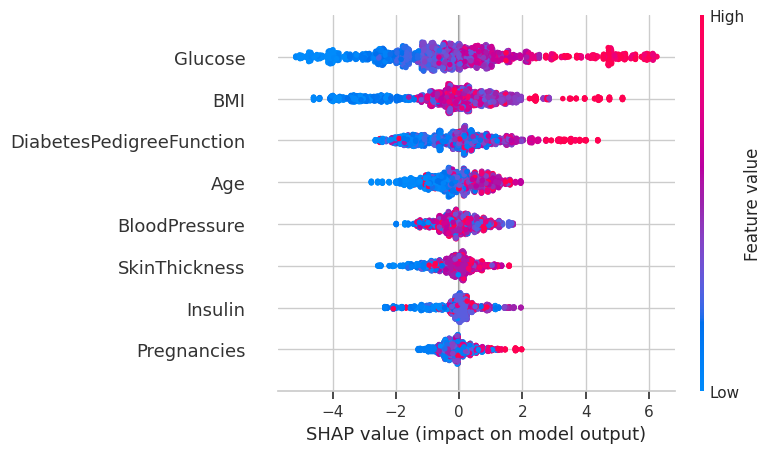

In [20]:
#1. Mostrar los coeficienties asociados a cada variable para la regresión logística

# Cree una lista de nombres de variables originales a partir del DataFrame de entrenamiento
variables_originales = X.columns

# Extraer los coeficientes del estimador de regresión logística
model_coefficients = logreg.coef_[0]

# Crear un dataframe de las variables y coeficientes e imprimir en orden descendiente
coefficient_df = pd.DataFrame({"Variable" : variables_originales, "Coefficient": model_coefficients})

print("---VARIABLES Y COEFICIENTES DE REGRESIÓN LOGÍSTICA---")
print(coefficient_df.sort_values(by="Coefficient", axis=0, ascending=False))

#2. Mostrar importancia de las variables y visualización del árbol

# Importancia de las variables
importancia = pd.DataFrame({'Variable': X.columns, 'Importancia': tree.feature_importances_})
importancia = importancia.sort_values(by='Importancia', ascending=False)

print("--- VARIABLES CLAVE SEGÚN EL ÁRBOL ---")
print(importancia.head(10))


#Visualización de una parte del árbol (Las reglas)
plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=list(X.columns), filled=True, rounded=True, max_depth=2, fontsize=10)
plt.title("Primeros niveles de decisión del Árbol")
plt.show()

# A continuación se mide el gain, es decir, cuánto mejora la capacidad de clasificación al usar esa variable
print("--- VARIABLES CLAVE SEGÚN CLASIFICADOR XGBOOST ---")

booster = xgb.get_booster()
importance = booster.get_score(importance_type="gain")

importance = pd.Series(importance).sort_values(ascending=False)
print(importance)

print("--- VISUALIZAR VARIABLES CLAVE CLASIFICADOR XGBOOST CON SHAP ---")
#Para entender qué variables influyen más y en qué dirección
#Valores SHAP positivos → empujan hacia la clase positiva
#Valores SHAP negativos → empujan hacia la clase negativa
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

### Guardar el modelo entrenado y el scaler

A pesar de que el árbol de decisión presenta un accuracy ligeramente superior al de la regresión logística, se decide seleccionar la regresión logística como el modelo final de predicción. El rendimiento perfecto obtenido por XGBoost (100 % de accuracy y F1-score) sugiere un posible sobreajuste, lo que indica que el modelo podría no generalizar adecuadamente a datos no vistos.

In [21]:
#Guardar el scaler
joblib.dump(scaler, 'scaler.pkl')
#Guardar el modelo
joblib.dump(logreg, 'modelo/modelo_diabetes.pkl')


['modelo/modelo_diabetes.pkl']

In [22]:
#Utilizando el modelo para predecir una nueva paciente no antes vista
input_data  = (2,130,96,0,0,22.6,0.268,21)
input_num_array = np.asarray(input_data)
reshape = input_num_array.reshape(1,-1)

std_data = scaler.transform(reshape)
prediction = logreg.predict(std_data)

print(prediction)

[0]


/workspaces/DiabetesScreening/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [23]:
input_df = pd.DataFrame([{
    "Pregnancies": 10,
    "Glucose": 90,
    "BloodPressure": 85,
    "SkinThickness": 32,
    "Insulin": 0,
    "BMI": 34.9,
    "DiabetesPedigreeFunction": 0.825,
    "Age": 56
}])
10,90,85,32,0,34.9,0.825,56
std_data = scaler.transform(input_df)
prediction = logreg.predict(std_data)
print(prediction)

[1]
